# Snakemake <img src="https://snakemake.github.io/img/jk/logo.png" width=100 />  

[Snakemake](https://snakemake.github.io/): a software tool for reproducible data analysis  

[docs](https://snakemake.readthedocs.io/en/stable/)

Let's start with watching the introductory [video](https://www.youtube.com/watch?v=UOKxta3061g)

As you have seen from the video, the main scope of snakemake is to provide a framework to tie together computing blocks in a consistent and reporducible way.
If we were to place snakemake in the data science software stack, it's probably best suited in the initial phase of data analysis, at the preprocessing step, before the exploratory data analysis.   

Snakemake is widely used in the bioinformatics community, where a lot of tools are needed for transforming your raw data in a *clean and meaningful* format. However, given the flexibility, the number of features that makes it robust and reproducible, and the fact that's writen in python, makes it for a great software tool for any type of data science project. For instance, I essentially use it as an interface to the cluster system. Any task that requires to submit more than 2 jobs to the cluster, I simply wrap it around a snakemake pipeline and submit it with that. I'll try to convince you that, despite an initial overhead, snakemake is very useful for this task.

As usual, it won't be neither exhaustive nor detailed, but a handpicked number of examples and use cases that I feel like it's worh highlighting

### But first, a spicy twitter thread:

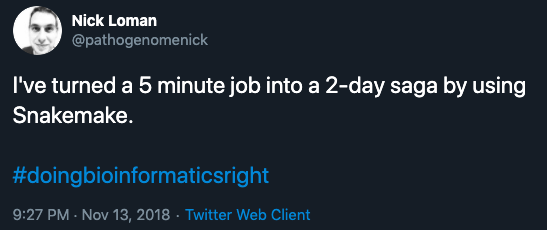

### More 
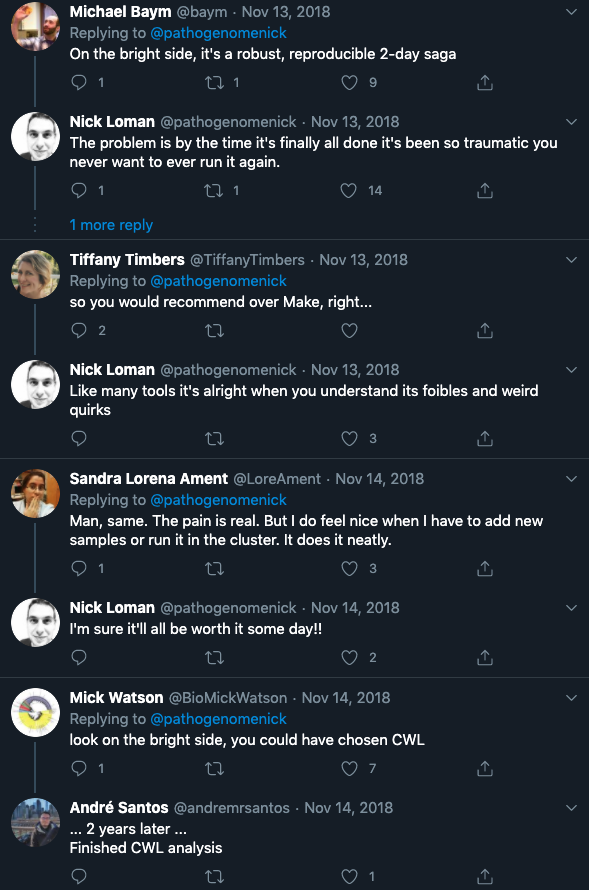

#### ...
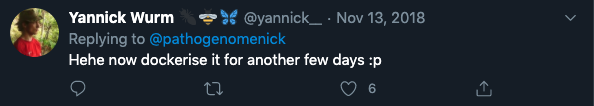

#### ....
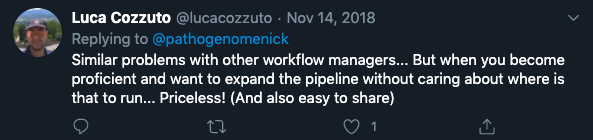

### Official docs are pretty good
Ok, let's go over them real [quick](https://snakemake.readthedocs.io/en/stable/tutorial/short.html)

### Wildcards

Wildcards are the core ingredient of snakemake. They essentially represents the keys around which the pipeline (the DAG) is built.  
<img src="https://snakemake.readthedocs.io/en/stable/_images/dag_call.png" width=500 />


We can go to another guide to illustrate better [here](https://snakemake.readthedocs.io/en/stable/tutorial/basics.html#step-4-indexing-read-alignments-and-visualizing-the-dag-of-jobs)

It's possible to create the DAG visualization with this: `snakemake --dag sorted_reads/{A,B}.bam.bai | dot -Tsvg > dag.svg`. See [here](https://snakemake.readthedocs.io/en/stable/tutorial/basics.html#step-4-indexing-read-alignments-and-visualizing-the-dag-of-jobs)


### How wildcards work
It's also important to understand how wildcards are called in the pipeline. For instance:

```python
rule FEATURE SELECTION:
    input:
        PATH + "/sc_hv_{hv}_{dataset}.h5ad"
    output:
        PATH+"/{n_features}_{hv}_{dataset}.h5ad"
    threads: 1
    conda: 
        PATH + "/myenv.yml"
    script:
        PATH + "/script.py"
```
In this case, we are gonna run X instances of the rule, where `X = sum(hv, n_features, dataset)`. If we were to submit to the cluster, each INSTANCE of the rule would be a SINGLE JOB.

### Wildcards and expand
Now, let's say that I actually want to run `script.py` only Z times, where `Z = sum(hv, dataset)`, but of course still outputing X files. Then we would use expand, and make it escape the wildcards.

```python
rule FEATURE SELECTION:
    input:
        PATH + "/sc_hv_{hv}_{dataset}.h5ad"
    output:
        expand(PATH+"/{n_features}_{{hv}}_{{dataset}}.h5ad", n_features = N_FEATURES_LIST)
    threads: 1
    conda: 
        PATH + "/myenv.yml"
    script:
        PATH + "/script.py"
```

### Rule all is the same

```python
rule all
    expand(PATH+"/{n_features}_{hv}_{dataset}.h5ad", 
           n_features = N_FEATURES_LIST,
           hv = HV_LIST,
           dataset = DATASET_LIST)
```

## Decorating the workflow

[docs](https://snakemake.readthedocs.io/en/stable/tutorial/advanced.html)

I'm gonna give you an example of a rule with additional decorations

```python
rule SCGENEFIT:
    input:
        cfg.get_outdir("highly_variable") + "/sc_hv_{hv}_{dataset}.h5ad"
    output:
        cfg.get_outdir("feature_selection")+"/scgenefit/{ps_fs}_{n_features}_{hv}_{dataset}.h5ad"
    params:
        lambda wildcards: cfg.FS_METHODS["scgenefit"][wildcards.ps_fs]
    log:
        cfg.get_logdir() + "/scgenefit/{ps_fs}_{n_features}_{hv}_{dataset}.LOG"
    benchmark:
        cfg.get_outdir("benchmarks") + "/feature_selection/scgenefit/{ps_fs}_{n_features}_{hv}_{dataset}.tsv"       
    threads: 1
    conda: 
        cfg.get_condadir() + "/scgenefit.yml"
    script:
         cfg.get_scriptdir() + "/feature_selection/scgenefit.py"
```
Another use of the params for additional input files. In general they make the construction of the pipeline very flexible

Lots of useful decorations, like logs, benchmarks, the conda environemnt (MOST IMPORTANTLY), but also stuff related to cluster submission.
Also params, see how it's used in this case. We are calling a wildcards (`ps_fs`, which is just a key) for the actual parameters in the `config.yaml` file.

#### `config.yaml`
```yaml
FS_METHODS:
  autogenes:
    ps1: [ngen: 5000, index: 1]
    # ps2: [0,1]
    script: "autogenes.py"
  scgenefit:
    ps1: [method: centers, epsilon: 1]
    # ps2: [0,1]
    script: "scgenefit.py"
  scanpyrgg:
    ps1: [method: t-test_overestim_var, corr_method: benjamini-hochberg]
    # ps2: [0,1]
    script: "scanpyrgg.py"
```

## Cluster configs and folder structure

We can have a look at the tutorial on cluster usage for some basic introduction [here](https://snakemake.readthedocs.io/en/stable/tutorial/additional_features.html#cluster-execution)

As you can see, it's just about adding to commandline the cluster directives, and Snakemake takes care of all the rest. Recently, Snakemake introduce the [profiles]() directive, which allows to have a more structured way to set config files for both the snakemake and cluster configs. See examples [here](https://snakemake.readthedocs.io/en/stable/executing/cli.html#profiles). 

Unfortunately, they don't make it for a very portable feature, as described in this [issue](https://github.com/Snakemake-Profiles/slurm/issues/51). You can also just stick to the old `cluster_config.yaml` version.

### Way I organize the profile folder
On a very personal and (what I think) practical level, this is how I organize my pipeline folder.

```
.
-- _config.yml
-- Snakefile
-- config.yaml
-- cluster_params.yaml
-- run_pipeline.sh
-- profile
|   -- cluster_config.yaml
|   -- config.yaml
```

Now the `Snakefile` and `config.yaml` we saw already examples above. The other additions are the following:

#### `cluster_params.yaml`
```yaml
cluster_dir:
[
"--ntasks 1",
"--parsable",
"-p {cluster.partition}",
"--exclude={cluster.exclude}",
"--job-name {cluster.job-name}",
"--cpus-per-task {cluster.cpus-per-task}",
"--nice={cluster.nice}",
"--mem {cluster.mem}",
"--time {cluster.time}",
"--output \"{cluster.output}\"",
"--error \"{cluster.error}\"",
"--gres={cluster.gres}",
]
```  

#### `run_pipeline.sh`
```bash
#!/bin/bash

RUN_CLUSTER=true
OIFS="$IFS"
IFS=" "

outputDir=$(niet .GENERAL_PARAMS.outdir ./config.yaml -f ifs)
logDirBasename="LOGS_AND_BENCHMARKS"
outputDirLog="${outputDir}/$logDirBasename"

# create outputdir and log directory
if [ ! -d "$outputDirLog" ]; then
    mkdir -p $outputDirLog
    if [ $? -ne 0 ] ; then
        echo "Error: Could not create directory $outputDirLog."
        #exit 1
    fi
fi

# create command for snakemake
COMMAND="snakemake -s Snakefile --configfile config.yaml --profile profile "

if [ "$RUN_CLUSTER" = true ] ; then
    echo 'Submitting to cluster, hostname is '$(uname -n)
    COMMAND="$COMMAND --cluster"
    CLUSTER="sbatch"
    for i in $(niet .cluster_dir ./cluster_params.yaml -f ifs); do
        CLUSTER="$CLUSTER $i"
    done
    echo "$COMMAND \"$CLUSTER\" "
    eval "$COMMAND \"$CLUSTER\" "
else
    echo "$COMMAND"
    eval "$COMMAND"
```

The profile folder instead, that has these two types of files

#### `config.yaml`
```yaml
# profile defaults
dryrun: False
restart-times: 0
local-cores: 1 # cores to run snakemake in cluster mode
cluster-config: ./profile/cluster_config.yaml # comment out if RUN_CLUSTER=False
jobs: 15
latency-wait: 10
verbose: False
use-conda: True
conda-prefix: /home/icb/giovanni.palla/miniconda3
keep-going: True
rerun-incomplete: False
```  

`cluster_config.yaml`
```yaml
__default__:
    partition: icb_supergpu # the partition you use
    job-name: fluovae.{rule}.{wildcards}
    time: 05:00:00 # default time (minutes)
    nice: 10000
    mem: 60GB # default memory
    cpus-per-task: 6
    output: /dir/output/LOGS_AND_BENCHMARKS/{rule}.{wildcards}.out
    error: /dir/output/LOGS_AND_BENCHMARKS/{rule}.{wildcards}.err
    gres: gpu:1
    exclude: icb-gpusrv[01-02]
```
    

### Why such configuration?
I ended up with this configuration because then I can have a profile file in each folder where I want to run the experiment. Also, the bash script builds the snakemake command that effectively submits the pipeline and it does it in an automated way.

This is the submitted command:
``` bash
snakemake -s Snakefile --configfile config.yaml --profile profile  --cluster "sbatch --ntasks 1 --parsable -p {cluster.partition} --exclude={cluster.exclude} --job-name {cluster.job-name} --cpus-per-task {cluster.cpus-per-task} --nice={cluster.nice} --mem {cluster.mem} --time {cluster.time} --output "{cluster.output}" --error "{cluster.error}" --gres={cluster.gres}"
```

which again, I just submitted by just doing `sh run_pipeline.sh`.

Another thing to notice is that , in the `cluster_config.yaml` file, you could have specific cluster configs for each rule, and the cluster arguments will simply be overidden for that specific rule. This is another great feature that makes it super convenient if you have rules with different specifications (even for example to be submitted in different nodes, e.g. some rules to cpu, some other to gpu)

For instance:
```yaml
    __default__:
        partition: icb_supergpu # the partition you use
        job-name: fluovae.{rule}.{wildcards}
        time: 05:00:00 # default time (minutes)
        nice: 10000
        mem: 60GB # default memory
        cpus-per-task: 6
        output: /dir/output/LOGS_AND_BENCHMARKS/{rule}.{wildcards}.out
        error: /dir/output/LOGS_AND_BENCHMARKS/{rule}.{wildcards}.err
        gres: gpu:1
        exclude: icb-gpusrv[01-02]
    CPU_RULE:
        partition: icb_cpu
        time: 01:00:00
```

### What a grid search could look like in snakemake?

Let's first see how you would run a grid search with bash:
```bash
for a in ${NCONV[@]}; do
    for b in ${LR[@]}; do
        for c in ${DROPOUT[@]}; do
            for d in ${L2COEF[@]}; do
                for e in ${L1COEF[@]}; do
                    for f in ${RESNET[@]}; do
                        for g in ${BATCHNORM[@]}; do
                            for h in ${EMBEDDING[@]}; do
                                for i in ${L2_KEYS[@]}; do
                                    echo "
                                    #!/bin/bash
                                    #SBATCH -J ${MODEL_CLASS}_${a}_${o}_${m}_${d}_${w}_${lr}_${dr}_${l1}_${l2}
                                    #SBATCH -o ${OUT_PATH}/jobs/run_${MODEL_CLASS}_${a}_${o}_${m}_${d}_${w}_${lr}_${dr}_${l1}_${l2}.out
                                    #SBATCH -e ${OUT_PATH}/jobs/run_${MODEL_CLASS}_${a}_${o}_${m}_${d}_${w}_${lr}_${dr}_${l1}_${l2}.err
                                    #SBATCH -p ${PARTITION}
                                    #SBATCH --nodes=1
                                    #SBATCH --ntasks=1
                                    #SBATCH --gres=gpu:1
                                    #SBATCH -t 2-00:00:00
                                    #SBATCH --mem=120G
                                    #SBATCH -c 15
                                    #SBATCH --exclude="badnod
                                    es"
                                    $HOME/.bashrc
                                    conda activate gpu-env
                                    python train_bigass_model.py" > ${job_file}
                                    sbatch $job_file
                                done
                            done
                        done
                    done
                done
            done
        done
    done
done
```

Now, true that once you have this script you can easily adapt it. But what if one of those x param set gets segmentation fault, or time limit or what not? Then you'd have to re-write another script that grep failed runs (by an instance check that you also need to come up with).

Snakemake, despite being maybe a bit more convoluted for this simple task, is in my opinion still clearer, more robust and less prone to error. Furthermore, if a run failed, you can simply just redo `Snakemake -s Snakefile ...` adn snakemake takes care of re building the DAG, see what's there and what not, and re run only specific param combinations. It's also more portable I'd say since you can specific `env.yaml` file for your grid search and let anybody reoproduce it as is.

#### `Snakefile`
So, the Snakefile would look something like this:
```python
rule TRAINING:
    input:
        path_files = config["INPUT_PATHS"]
    output:
        weights = OUTPUT_DIR+"/{kernel_size}_{filters}_{l2_coef}_{n_residuals}_{n_conv}_{activation}_{latent_dim}_{se_layer}_{encoding_split}_{model_sets}/weights.index",
        model_params = OUTPUT_DIR+"/param_dic/{kernel_size}_{filters}_{l2_coef}_{n_residuals}_{n_conv}_{activation}_{latent_dim}_{se_layer}_{encoding_split}_{model_sets}/model_params.json",
        training_params = OUTPUT_DIR+"/param_dic/{kernel_size}_{filters}_{l2_coef}_{n_residuals}_{n_conv}_{activation}_{latent_dim}_{se_layer}_{encoding_split}_{model_sets}/training_params.json",
        hyper_params = OUTPUT_DIR+"/param_dic/{kernel_size}_{filters}_{l2_coef}_{n_residuals}_{n_conv}_{activation}_{latent_dim}_{se_layer}_{encoding_split}_{model_sets}/hyper_params.json",
        train_history = OUTPUT_DIR+"/param_dic/{kernel_size}_{filters}_{l2_coef}_{n_residuals}_{n_conv}_{activation}_{latent_dim}_{se_layer}_{encoding_split}_{model_sets}/train_history.csv.gz",
        latents_df = OUTPUT_DIR+"/param_dic/{kernel_size}_{filters}_{l2_coef}_{n_residuals}_{n_conv}_{activation}_{latent_dim}_{se_layer}_{encoding_split}_{model_sets}/latents_df.csv.gz"
    params:
        tb_callback = OUTPUT_DIR+"/hparam/{kernel_size}_{filters}_{l2_coef}_{n_residuals}_{n_conv}_{activation}_{latent_dim}_{se_layer}_{encoding_split}_{model_sets}",
        training_params = config['TRAINING_PARAMS']
    log:
        training_log = OUTPUT_DIR+"/logs/{kernel_size}_{filters}_{l2_coef}_{n_residuals}_{n_conv}_{activation}_{latent_dim}_{se_layer}_{encoding_split}_{model_sets}.LOG"
    threads: 10
    script:
        config["SCRIPTS"]
```

Now, you don't need to be this verbose. I think being explicit on all your inputs and outputs is more useful but of course you could just add a single path and the model output

#### `config.yaml`
```yaml
GENERAL_PARAMS: 
  outdir: /outdir/training/64/output
  indir: /indir/training/64

INPUT_PATHS:
  path_files: /storage/groups/ml01/datasets/dataset
  train_df: /path/to/folder/dat/train_filter.csv.gz
  test_df: /path/to/folder/dat/test_filter.csv.gz
  full_df: /path/to/folder/dat/full_filter.csv.gz

HYPER_PARAMS:
  kernel_size: [5]
  filters: [64]
  l2_coef: [1e-5,1e-6]
  n_residuals: [1,2]
  n_conv: [3]
  activation: ["swish","elu"]
  latent_dim: [64]
  se_layer: [1,0]
  encoding_split: [0]
  model_sets:
    flowvae1:
      type: FlowVAE
      start_annealweight: 0
      final_annealweight: 0.1
      n_flow: 6
    vae1:
      type: VAE
      start_annealweight: 0
      final_annealweight: 0.1
    rae1:
      type: RAE
      l2_weight: 1e-5

TRAINING_PARAMS:
  input_shape: [64,64,3]
  batch_size: 128
  epochs: 20
  lr: 1e-3
  resize_method: "bilinear"
  encode: 0
```

Also, checkout **hyperband in snakemake** by Emilio [here](https://github.com/e-dorigatti/hyperband-snakemake/)